# Figure 10 & 11

**Figure 10.** Mean uncertainties in CRH diagnosed as the absolute difference of domain and time mean CRH between different radiative transfer calculations. Uncertainties are decomposed into shortwave, longwave, and net. Uncertainties are computed as mass-weighted averages over 2 \unit{km} altitude intervals. For the uncertainty due to the ice-optical parameterization, the difference between the ice schemes of Fu and Baum with the general habit mixture is used. The contribution of each factor is given by the horizontal length of its colored bar. Note the different x-axes in the panels.

**Figure 11.** Same as Fig. 10 but for local uncertainties of net CRH. For comparison, the mean values of net CRH uncertainty from Fig. 10 are superimposed as hatched bars. Note the different x-axes in the panels.

---
@ Behrooz Keshtgar, KIT 2023

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import colorlegend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.23.5
matplotlib: 3.3.0


**Since datasets are large, I use DASK to speed up my analysis**

In [3]:
import dask
from dask.distributed import Client, progress, wait
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
client = Client()
client

<Client: 'tcp://127.0.0.1:43319' processes=16 threads=256, memory=252.72 GB>

## 2- Loading datasets

In [4]:
# Dictionary for loading datasets for the 4 simulations
simdict = {
         'LC1-LES-471x667km-lon25-lat40-300m-0006' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon40-lat44-300m-0003' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon30-lat53-300m-0005' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
         'LC1-LES-471x667km-lon50-lat48-300m-0004' : {'res':'300', 'radiation':4, 'mphy':4}, # Only cloud radiation
          }

In [5]:
# all libradtrn calculations 
def load_simulations(num):
    ds_list = []
    sim = list(simdict.keys())[num]
    print('Working on loading data for', sim)
    path = '/work/bb1135/icon_output/'+sim+'/input4libradtran/libradtran/output_netcdf/'
    for solver in ['ipa3d','mysti','mcipa']:#,'nca']:
        # loop over sources (thermal/solar)
        for source in ['thermal','solar']:
            # loop over sim types
            for nsim in ['01']: # simulations with Fu for ice param
                if solver in ['mysti','mcipa']:
                    ds = xr.open_mfdataset(path+'ds_librad_05T*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested',
                                           chunks={'height': 50},parallel=True).isel(height=slice(0,140))
                else:
                    ds = xr.open_mfdataset(path+'ds_librad2_05T*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested',
                                           chunks={'height': 50},parallel=True).isel(height=slice(0,140))
                ds.attrs['sim_name'] = 'ds_librad_'+source+'_'+solver+'_'+nsim+''
                ds_list.append(ds)
    return ds_list                
#-------------------------------------
ds_lib1=load_simulations(0)
ds_lib2=load_simulations(1)
ds_lib3=load_simulations(2)
ds_lib4=load_simulations(3)
#-------------------------------------
# libradtrn simulations with homogenized 
def load_simulations1(num):
    ds_list = []
    sim = list(simdict.keys())[num]
    print('Working on loading data for', sim)
    path = '/work/bb1135/icon_output/'+sim+'/input4libradtran/libradtran/output_netcdf/'
    for solver in ['ipa3d']:
        # loop over sources (thermal/solar)
        for source in ['thermal','solar']:
            # loop over sim types
            for nsim in ['01']: # simulations with ice param of Fu (1998)
                #--------------------------------------------------
                # delta-eddington two-stream using homogenized clouds 
                # with 2.5 km horizontal resolution
                ds1 = xr.open_mfdataset(path+'ds_librad_dl_*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested').isel(height=slice(0,140))
                ds1.attrs['sim_name'] = 'ds_librad_dl_'+source+'_'+solver+'_'+nsim+''
                ds_list.append(ds1)
                #--------------------------------------------------
                # delta-eddington two-stream using homogenized clouds with fractions 
                # at 2.5 km horizontal resolution
                ds2 = xr.open_mfdataset(path+'ds_librad_cg_*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested').isel(height=slice(0,140))
                ds2.attrs['sim_name'] = 'ds_librad_cg_'+source+'_'+solver+'_'+nsim+''
                ds_list.append(ds2)
    return ds_list                
#-------------------------------------
tmp1=load_simulations1(0)
tmp2=load_simulations1(1)
tmp3=load_simulations1(2)
tmp4=load_simulations1(3)

## add to the original datasets 

ds_lib1.append(tmp1[0])
ds_lib1.append(tmp1[1])
ds_lib1.append(tmp1[2])
ds_lib1.append(tmp1[3])

ds_lib2.append(tmp2[0])
ds_lib2.append(tmp2[1])
ds_lib2.append(tmp2[2])
ds_lib2.append(tmp2[3])

ds_lib3.append(tmp3[0])
ds_lib3.append(tmp3[1])
ds_lib3.append(tmp3[2])
ds_lib3.append(tmp3[3])

ds_lib4.append(tmp4[0])
ds_lib4.append(tmp4[1])
ds_lib4.append(tmp4[2])
ds_lib4.append(tmp4[3])
#-------------------------------------
# libradtrn simulation using other ice parametrization
def load_simulations3(num):
    ds_list = []
    sim = list(simdict.keys())[num]
    print('Working on loading data for', sim)
    path = '/work/bb1135/icon_output/'+sim+'/input4libradtran/libradtran/output_netcdf/'
    for solver in ['ipa3d']:
        # loop over sources (thermal/solar)
        for source in ['thermal','solar']:
            # loop over sim types
            for nsim in ['02']: # simulations with Baum_ghm for ice param    
                ds = xr.open_mfdataset(path+'ds_librad2_05T*_'+source+'_'+solver+'_'+nsim+'.nc',concat_dim='time',combine='nested',
                                      chunks={'height': 50},parallel=True).isel(height=slice(0,140))
                ds.attrs['sim_name'] = 'ds_librad_'+source+'_'+solver+'_'+nsim+''
                ds_list.append(ds)
    return ds_list                
#-------------------------------------
tmp22=load_simulations3(1)
tmp33=load_simulations3(2)
tmp44=load_simulations3(3)
#-------------------------------------
## add to the original datasets 
ds_lib2.append(tmp22[0])
ds_lib2.append(tmp22[1])
ds_lib3.append(tmp33[0])
ds_lib3.append(tmp33[1])
ds_lib4.append(tmp44[0])
ds_lib4.append(tmp44[1])

## height values at full-levels
z_ifc = xr.open_dataset('/work/bb1135/icon_output/LC1-LES-471x667km-lon40-lat44-300m-0003/icon-atm3d_ML_20220105T120033Z.nc')["z_ifc"].isel(ncells=20000)
z_fl  = ((z_ifc - z_ifc.diff('height_3')/2).values)*1e-3 # km
# select between index 0:140
z_fl2  = z_fl[10:150][::-1]


# loading remmapped density for weight vertical mean
ds_ico1 = xr.open_mfdataset('/work/bb1135/icon_output/'+list(simdict.keys())[0]+'/input4libradtran/icon_rho*.nc',
                            concat_dim='time',combine='nested').isel(height=slice(0,140))
ds_ico2 = xr.open_mfdataset('/work/bb1135/icon_output/'+list(simdict.keys())[1]+'/input4libradtran/icon_rho*.nc',
                            concat_dim='time',combine='nested').isel(height=slice(0,140))
ds_ico3 = xr.open_mfdataset('/work/bb1135/icon_output/'+list(simdict.keys())[2]+'/input4libradtran/icon_rho*.nc',
                            concat_dim='time',combine='nested').isel(height=slice(0,140))
ds_ico4 = xr.open_mfdataset('/work/bb1135/icon_output/'+list(simdict.keys())[3]+'/input4libradtran/icon_rho*.nc',
                            concat_dim='time',combine='nested').isel(height=slice(0,140))

Working on loading data for LC1-LES-471x667km-lon25-lat40-300m-0006
Working on loading data for LC1-LES-471x667km-lon40-lat44-300m-0003
Working on loading data for LC1-LES-471x667km-lon30-lat53-300m-0005
Working on loading data for LC1-LES-471x667km-lon50-lat48-300m-0004
Working on loading data for LC1-LES-471x667km-lon25-lat40-300m-0006
Working on loading data for LC1-LES-471x667km-lon40-lat44-300m-0003
Working on loading data for LC1-LES-471x667km-lon30-lat53-300m-0005
Working on loading data for LC1-LES-471x667km-lon50-lat48-300m-0004
Working on loading data for LC1-LES-471x667km-lon40-lat44-300m-0003
Working on loading data for LC1-LES-471x667km-lon30-lat53-300m-0005
Working on loading data for LC1-LES-471x667km-lon50-lat48-300m-0004


## 3- Derving CRH uncertainties
### 3.1 -Domain and time mean

In [6]:
# loop over libradtran simulations and compute domain and time mean of CRH
# we also exclude the lateral booundray points in our analysis
for i in range(12):
    if i in range(0,6):
        ds_lib1[i]['ddt_radlw_mean'] = ds_lib1[i]['ddt_radlw'].isel(lon=slice(10,ds_lib1[i].lon.size-10),lat=slice(5,ds_lib1[i].lat.size-5)).mean(dim=['lat','lon','time']).compute()
        ds_lib2[i]['ddt_radlw_mean'] = ds_lib2[i]['ddt_radlw'].isel(lon=slice(10,ds_lib2[i].lon.size-10),lat=slice(5,ds_lib2[i].lat.size-5)).mean(dim=['lat','lon','time']).compute()
        ds_lib3[i]['ddt_radlw_mean'] = ds_lib3[i]['ddt_radlw'].isel(lon=slice(10,ds_lib3[i].lon.size-10),lat=slice(5,ds_lib3[i].lat.size-5)).mean(dim=['lat','lon','time']).compute()
        ds_lib4[i]['ddt_radlw_mean'] = ds_lib4[i]['ddt_radlw'].isel(lon=slice(10,ds_lib4[i].lon.size-10),lat=slice(5,ds_lib4[i].lat.size-5)).mean(dim=['lat','lon','time']).compute()
        
    elif i in range(6,10):
        ds_lib1[i]['ddt_radlw_mean'] = ds_lib1[i]['ddt_radlw'].isel(lon=slice(1,ds_lib1[i].lon.size-1),lat=slice(1,ds_lib1[i].lat.size-1)).mean(dim=['lat','lon','time']).compute()
        ds_lib2[i]['ddt_radlw_mean'] = ds_lib2[i]['ddt_radlw'].isel(lon=slice(1,ds_lib2[i].lon.size-1),lat=slice(1,ds_lib2[i].lat.size-1)).mean(dim=['lat','lon','time']).compute()
        ds_lib3[i]['ddt_radlw_mean'] = ds_lib3[i]['ddt_radlw'].isel(lon=slice(1,ds_lib3[i].lon.size-1),lat=slice(1,ds_lib3[i].lat.size-1)).mean(dim=['lat','lon','time']).compute()
        ds_lib4[i]['ddt_radlw_mean'] = ds_lib4[i]['ddt_radlw'].isel(lon=slice(1,ds_lib4[i].lon.size-1),lat=slice(1,ds_lib4[i].lat.size-1)).mean(dim=['lat','lon','time']).compute()
        
    else:
        ds_lib2[i]['ddt_radlw_mean'] = ds_lib2[i]['ddt_radlw'].isel(lon=slice(10,ds_lib2[i].lon.size-10),lat=slice(5,ds_lib2[i].lat.size-5)).mean(dim=['lat','lon','time']).compute()
        ds_lib3[i]['ddt_radlw_mean'] = ds_lib3[i]['ddt_radlw'].isel(lon=slice(10,ds_lib3[i].lon.size-10),lat=slice(5,ds_lib3[i].lat.size-5)).mean(dim=['lat','lon','time']).compute()
        ds_lib4[i]['ddt_radlw_mean'] = ds_lib4[i]['ddt_radlw'].isel(lon=slice(10,ds_lib4[i].lon.size-10),lat=slice(5,ds_lib4[i].lat.size-5)).mean(dim=['lat','lon','time']).compute()

# compute domain and time mean of density       
p1 = ds_ico1['rho'].isel(lon=slice(10,ds_ico1.lon.size-10),lat=slice(5,ds_ico1.lat.size-5)).mean(dim=['lat','lon','time']).compute()
p2 = ds_ico2['rho'].isel(lon=slice(10,ds_ico2.lon.size-10),lat=slice(5,ds_ico2.lat.size-5)).mean(dim=['lat','lon','time']).compute()     
p3 = ds_ico3['rho'].isel(lon=slice(10,ds_ico3.lon.size-10),lat=slice(5,ds_ico3.lat.size-5)).mean(dim=['lat','lon','time']).compute()     
p4 = ds_ico4['rho'].isel(lon=slice(10,ds_ico4.lon.size-10),lat=slice(5,ds_ico4.lat.size-5)).mean(dim=['lat','lon','time']).compute()     

### 3.2 absolute diff and weighted vertical mean

In [7]:
# calculating root square of CRH differences and weighted vertical mean in vertical intervals of 2 km
def crh_uncertainty(ds,p):
    
    # mean absolute error
    td_er_lw = np.abs((ds[2]['ddt_radlw_mean'] - ds[4]['ddt_radlw_mean']).values) # 3D cloud radiative effects
    td_er_sw = np.abs((ds[3]['ddt_radlw_mean'] - ds[5]['ddt_radlw_mean']).values) # 3D cloud radiative effects

    ho_er_lw = np.abs((ds[6]['ddt_radlw_mean'] - ds[0]['ddt_radlw_mean']).values) # unresolved cloud horizontal heterogeneity and cloud overlap
    ho_er_sw = np.abs((ds[8]['ddt_radlw_mean'] - ds[1]['ddt_radlw_mean']).values) # unresolved cloud horizontal heterogeneity and cloud overlap

    hl_er_lw = np.abs((ds[7]['ddt_radlw_mean'] - ds[0]['ddt_radlw_mean']).values) # unresolved cloud horizontal heterogeneity 
    hl_er_sw = np.abs((ds[9]['ddt_radlw_mean'] - ds[1]['ddt_radlw_mean']).values) # unresolved cloud horizontal heterogeneity
    
    if ds == ds_lib1:
        ic_er_lw = ho_er_lw*0.0 
        ic_er_sw = ho_er_lw*0.0 
    else:
        ic_er_lw = np.abs((ds[0]['ddt_radlw_mean'] - ds[10]['ddt_radlw_mean']).values) # ice-optical parameterization
        ic_er_sw = np.abs((ds[1]['ddt_radlw_mean'] - ds[11]['ddt_radlw_mean']).values) # ice-optical parameterization

    # thickness for weight vertical mean 
    dp = np.zeros((140))
    dp[1:-1] = (p[2:] - p[:-2]) 
    dp[0] = (p[1] - p[0]) 
    dp[-1] = (p[-1] - p[-2])
    dp = dp[::-1]

    ######## longwave ##########
    # 3D cloud radiative effects
    unc_3d_lw = np.array([((td_er_lw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((td_er_lw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((td_er_lw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((td_er_lw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((td_er_lw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((td_er_lw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # unresolved cloud horizontal heterogeneity and cloud overlap
    unc_ho_lw = np.array([((ho_er_lw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((ho_er_lw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((ho_er_lw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((ho_er_lw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((ho_er_lw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((ho_er_lw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # unresolved cloud horizontal heterogeneity 
    unc_hl_lw = np.array([((hl_er_lw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((hl_er_lw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((hl_er_lw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((hl_er_lw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((hl_er_lw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((hl_er_lw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # ice-optical parameterization
    unc_ic_lw = np.array([((ic_er_lw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((ic_er_lw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((ic_er_lw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((ic_er_lw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((ic_er_lw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((ic_er_lw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    

    ######## shortwave #########
    # 3D cloud radiative effects
    unc_3d_sw = np.array([((td_er_sw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((td_er_sw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((td_er_sw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((td_er_sw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((td_er_sw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((td_er_sw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # unresolved cloud horizontal heterogeneity and cloud overlap
    unc_ho_sw = np.array([((ho_er_sw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((ho_er_sw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((ho_er_sw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((ho_er_sw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((ho_er_sw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((ho_er_sw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # unresolved cloud horizontal heterogeneity 
    unc_hl_sw = np.array([((hl_er_sw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((hl_er_sw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((hl_er_sw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((hl_er_sw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((hl_er_sw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((hl_er_sw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # ice-optical parameterization
    unc_ic_sw = np.array([((ic_er_sw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((ic_er_sw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((ic_er_sw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((ic_er_sw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((ic_er_sw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((ic_er_sw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    return unc_3d_lw, unc_ho_lw, unc_hl_lw, unc_ic_lw, unc_3d_sw, unc_ho_sw, unc_hl_sw, unc_ic_sw

In [8]:
# calling the function
d1_unc_3d_lw, d1_unc_ho_lw, d1_unc_hl_lw, d1_unc_ic_lw, d1_unc_3d_sw, d1_unc_ho_sw, d1_unc_hl_sw, d1_unc_ic_sw = crh_uncertainty(ds_lib1,p1.values)
d2_unc_3d_lw, d2_unc_ho_lw, d2_unc_hl_lw, d2_unc_ic_lw, d2_unc_3d_sw, d2_unc_ho_sw, d2_unc_hl_sw, d2_unc_ic_sw = crh_uncertainty(ds_lib2,p2.values)
d3_unc_3d_lw, d3_unc_ho_lw, d3_unc_hl_lw, d3_unc_ic_lw, d3_unc_3d_sw, d3_unc_ho_sw, d3_unc_hl_sw, d3_unc_ic_sw = crh_uncertainty(ds_lib3,p3.values)
d4_unc_3d_lw, d4_unc_ho_lw, d4_unc_hl_lw, d4_unc_ic_lw, d4_unc_3d_sw, d4_unc_ho_sw, d4_unc_hl_sw, d4_unc_ic_sw = crh_uncertainty(ds_lib4,p4.values)

# deriving total uncertainties
d1_unc_3d_nt = d1_unc_3d_lw + d1_unc_3d_sw ; d1_unc_ho_nt = d1_unc_ho_lw + d1_unc_ho_sw ; d1_unc_hl_nt = d1_unc_hl_lw + d1_unc_hl_sw ; d1_unc_ic_nt = d1_unc_ic_lw + d1_unc_ic_sw
d2_unc_3d_nt = d2_unc_3d_lw + d2_unc_3d_sw ; d2_unc_ho_nt = d2_unc_ho_lw + d2_unc_ho_sw ; d2_unc_hl_nt = d2_unc_hl_lw + d2_unc_hl_sw ; d2_unc_ic_nt = d2_unc_ic_lw + d2_unc_ic_sw
d3_unc_3d_nt = d3_unc_3d_lw + d3_unc_3d_sw ; d3_unc_ho_nt = d3_unc_ho_lw + d3_unc_ho_sw ; d3_unc_hl_nt = d3_unc_hl_lw + d3_unc_hl_sw ; d3_unc_ic_nt = d3_unc_ic_lw + d3_unc_ic_sw
d4_unc_3d_nt = d4_unc_3d_lw + d4_unc_3d_sw ; d4_unc_ho_nt = d4_unc_ho_lw + d4_unc_ho_sw ; d4_unc_hl_nt = d4_unc_hl_lw + d4_unc_hl_sw ; d4_unc_ic_nt = d4_unc_ic_lw + d1_unc_ic_sw

## 4- Plot

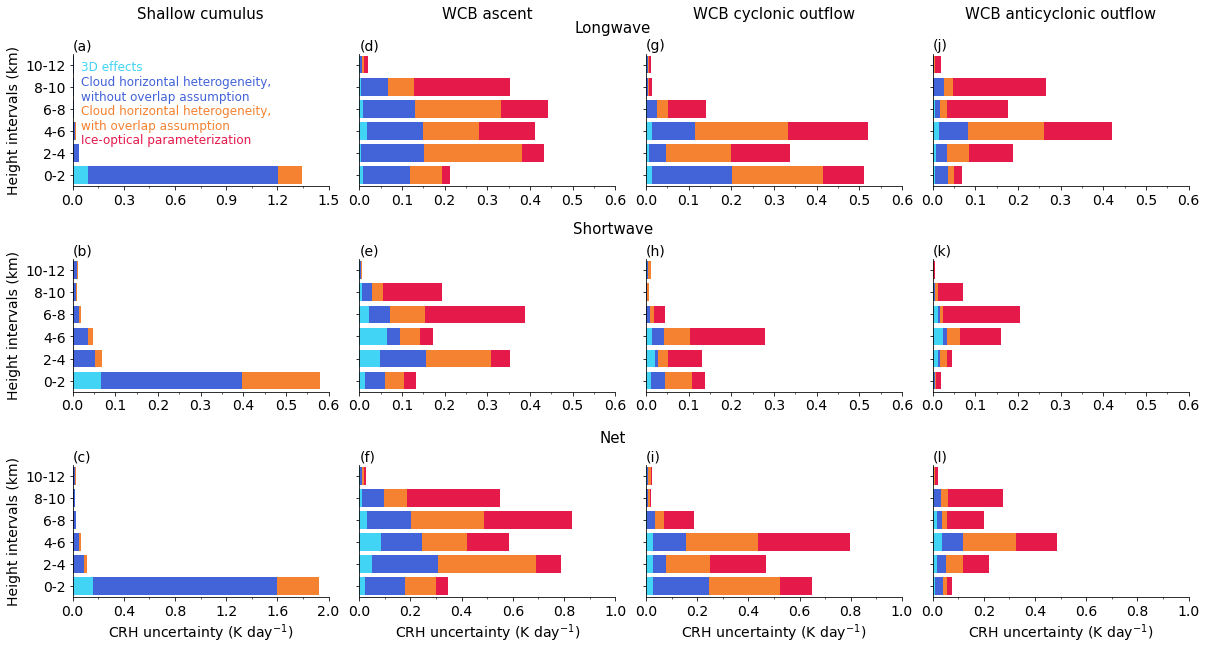

In [9]:
# height intervals
h1 = np.arange(0,6,1)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10)) 
i = 0

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
    ############################################################
    ####### Longwave ###########################################
    ############################################################
    if i == 0:

        ax.barh(h1, d1_unc_3d_lw, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d1_unc_ho_lw, color='#4363d8', left=d1_unc_3d_lw, label='Horizontal heterogeneity')
        ax.barh(h1, d1_unc_hl_lw, color='#f58231', left=d1_unc_3d_lw+d1_unc_ho_lw, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d1_unc_ic_lw, color='#e6194B', left=d1_unc_3d_lw+d1_unc_ho_lw+d1_unc_hl_lw, label='Ice-optical parameterization')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.legend(frameon=False)
        ax.set_title('Shallow cumulus', fontsize=15,pad=35)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        
        ax.set_xlim([0.,1.5])
        ax.spines['bottom'].set_bounds(0,1.5)
        ax.set_xticks(np.linspace(0,1.5,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(a)', transform=ax.transAxes, 
            size=14)
        
        
        #ax.text(0.05, 5.2, '3D effects', color = '#42d4f4', size=12, va="top")
        #ax.text(0.05, 4.5, 'Unresoved cloud horizontal heterogeneity\nand vertical overlap', color='#4363d8', size=12, va="top")
        #ax.text(0.05, 3.2, 'Unresoved cloud horizontal heterogeneity', color='#f58231', size=12, va="top")
        #ax.text(0.05, 2.5, 'Ice-optical parameterization', color='#e6194B', size=12, va="top")
        
        ax.text(0.05, 5.2, '3D effects', color = '#42d4f4', size=12, va="top")
        ax.text(0.05, 4.5, 'Cloud horizontal heterogeneity,\nwithout overlap assumption', color='#4363d8', size=12, va="top")
        ax.text(0.05, 3.2, 'Cloud horizontal heterogeneity,\nwith overlap assumption', color='#f58231', size=12, va="top")
        ax.text(0.05, 1.9, 'Ice-optical parameterization', color='#e6194B', size=12, va="top")
        
    if i == 1:

        ax.barh(h1, d2_unc_3d_lw, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d2_unc_ho_lw, color='#4363d8', left=d2_unc_3d_lw, label='Horizontal heterogeneity')
        ax.barh(h1, d2_unc_hl_lw, color='#f58231', left=d2_unc_3d_lw+d2_unc_ho_lw, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d2_unc_ic_lw, color='#e6194B', left=d2_unc_3d_lw+d2_unc_ho_lw+d2_unc_hl_lw, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        ax.set_title('WCB ascent', fontsize=15,pad=35)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(d)', transform=ax.transAxes, 
            size=14)
        
    if i == 2:

        ax.barh(h1, d3_unc_3d_lw, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d3_unc_ho_lw, color='#4363d8', left=d3_unc_3d_lw, label='Horizontal heterogeneity')
        ax.barh(h1, d3_unc_hl_lw, color='#f58231', left=d3_unc_3d_lw+d3_unc_ho_lw, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d3_unc_ic_lw, color='#e6194B', left=d3_unc_3d_lw+d3_unc_ho_lw+d3_unc_hl_lw, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        ax.set_title('WCB cyclonic outflow', fontsize=15,pad=35)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(g)', transform=ax.transAxes, 
            size=14)
        
    
    if i == 3:

        ax.barh(h1, d4_unc_3d_lw, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d4_unc_ho_lw, color='#4363d8', left=d4_unc_3d_lw, label='Horizontal heterogeneity')
        ax.barh(h1, d4_unc_hl_lw, color='#f58231', left=d4_unc_3d_lw+d4_unc_ho_lw, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d4_unc_ic_lw, color='#e6194B', left=d4_unc_3d_lw+d4_unc_ho_lw+d4_unc_hl_lw, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=35)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(j)', transform=ax.transAxes, 
            size=14)
        
    ############################################################
    ####### Shortwave ##########################################
    ############################################################
    
    if i == 4:

        ax.barh(h1, d1_unc_3d_sw, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d1_unc_ho_sw, color='#4363d8', left=d1_unc_3d_sw, label='Horizontal heterogeneity')
        ax.barh(h1, d1_unc_hl_sw, color='#f58231', left=d1_unc_3d_sw+d1_unc_ho_sw, label='Horizontal heterogeneity and vertical overlap')
        #ax.barh(h1, d1_unc_ic_sw, color='#e6194B', left=d1_unc_3d_sw+d1_unc_ho_sw+d1_unc_hl_sw, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('Shallow cumulus', fontsize=15,pad=15)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        
        ax.set_xlim([0.0,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks(np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(b)', transform=ax.transAxes, 
            size=14)
        
    if i == 5:

        ax.barh(h1, d2_unc_3d_sw, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d2_unc_ho_sw, color='#4363d8', left=d2_unc_3d_sw, label='Horizontal heterogeneity')
        ax.barh(h1, d2_unc_hl_sw, color='#f58231', left=d2_unc_3d_sw+d2_unc_ho_sw, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d2_unc_ic_sw, color='#e6194B', left=d2_unc_3d_sw+d2_unc_ho_sw+d2_unc_hl_sw, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB ascent', fontsize=15,pad=15)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.0,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks(np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(e)', transform=ax.transAxes, 
            size=14)
        
    if i == 6:

        ax.barh(h1, d3_unc_3d_sw, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d3_unc_ho_sw, color='#4363d8', left=d3_unc_3d_sw, label='Horizontal heterogeneity')
        ax.barh(h1, d3_unc_hl_sw, color='#f58231', left=d3_unc_3d_sw+d3_unc_ho_sw, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d3_unc_ic_sw, color='#e6194B', left=d3_unc_3d_sw+d3_unc_ho_sw+d3_unc_hl_sw, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB cyclonic outflow', fontsize=15,pad=15)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.0,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks(np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(h)', transform=ax.transAxes, 
            size=14)
        
    
    if i == 7:

        ax.barh(h1, d4_unc_3d_sw, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d4_unc_ho_sw, color='#4363d8', left=d4_unc_3d_sw, label='Horizontal heterogeneity')
        ax.barh(h1, d4_unc_hl_sw, color='#f58231', left=d4_unc_3d_sw+d4_unc_ho_sw, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d4_unc_ic_sw, color='#e6194B', left=d4_unc_3d_sw+d4_unc_ho_sw+d4_unc_hl_sw, label='Ice-optical pa')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=15)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.0,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks(np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(k)', transform=ax.transAxes, 
            size=14)
        
    ############################################################
    ####### Net###### ##########################################
    ############################################################
    
    if i == 8:

        ax.barh(h1, d1_unc_3d_nt, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d1_unc_ho_nt, color='#4363d8', left=d1_unc_3d_nt, label='Horizontal heterogeneity')
        ax.barh(h1, d1_unc_hl_nt, color='#f58231', left=d1_unc_3d_nt+d1_unc_ho_nt, label='Horizontal heterogeneity and vertical overlap')
        #ax.barh(h1, d1_unc_ic_nt, color='#e6194B', left=d1_unc_3d_nt+d1_unc_ho_nt+d1_unc_hl_nt, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('Shallow cumulus', fontsize=15,pad=15)
        ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        
        ax.set_xlim([0.,2])
        ax.spines['bottom'].set_bounds(0,2)
        ax.set_xticks(np.linspace(0,2,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(c)', transform=ax.transAxes, 
            size=14)
        
        #table = ax.table(cellText=d1_df.values, colLabels=None, loc='center',bbox=[0, -1.5, 1, 1],rowLabels=d1_df.index,colColours=ccolors)
        #table.auto_set_font_size(False)
        #table.set_fontsize(13)
        #table.scale(1, 1)
        #cellDict = table.get_celld()
        #cellDict[(0,0)].set_height(0.01);cellDict[(0,1)].set_height(0.01);cellDict[(0,2)].set_height(0.01);cellDict[(0,3)].set_height(0.01)
        
    if i == 9:

        ax.barh(h1, d2_unc_3d_nt, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d2_unc_ho_nt, color='#4363d8', left=d2_unc_3d_nt, label='Horizontal heterogeneity')
        ax.barh(h1, d2_unc_hl_nt, color='#f58231', left=d2_unc_3d_nt+d2_unc_ho_nt, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d2_unc_ic_nt, color='#e6194B', left=d2_unc_3d_nt+d2_unc_ho_nt+d2_unc_hl_nt, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB ascent', fontsize=15,pad=15)
        ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.0,1])
        ax.spines['bottom'].set_bounds(0,1)
        ax.set_xticks(np.linspace(0,1,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(f)', transform=ax.transAxes, 
            size=14)
        
        #table = ax.table(cellText=d2_df.values, colLabels=None, loc='center',bbox=[0, -1.5, 1, 1],colColours=ccolors)
        #table.auto_set_font_size(False)
        #table.set_fontsize(13)
        #table.scale(1, 1)
        #cellDict = table.get_celld()
        #cellDict[(0,0)].set_height(0.01);cellDict[(0,1)].set_height(0.01);cellDict[(0,2)].set_height(0.01);cellDict[(0,3)].set_height(0.01)
        
    if i == 10:

        ax.barh(h1, d3_unc_3d_nt, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d3_unc_ho_nt, color='#4363d8', left=d3_unc_3d_nt, label='Horizontal heterogeneity')
        ax.barh(h1, d3_unc_hl_nt, color='#f58231', left=d3_unc_3d_nt+d3_unc_ho_nt, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d3_unc_ic_nt, color='#e6194B', left=d3_unc_3d_nt+d3_unc_ho_nt+d3_unc_hl_nt, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB cyclonic outflow', fontsize=15,pad=15)
        ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.0,1])
        ax.spines['bottom'].set_bounds(0,1)
        ax.set_xticks(np.linspace(0,1,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(i)', transform=ax.transAxes, 
            size=14)
        
        #table = ax.table(cellText=d3_df.values, colLabels=None, loc='center',bbox=[0, -1.5, 1, 1],colColours=ccolors)
        #table.auto_set_font_size(False)
        #table.set_fontsize(13)
        #table.scale(1, 1)
        #cellDict = table.get_celld()
        #cellDict[(0,0)].set_height(0.01);cellDict[(0,1)].set_height(0.01);cellDict[(0,2)].set_height(0.01);cellDict[(0,3)].set_height(0.01)
    
    if i == 11:

        ax.barh(h1, d4_unc_3d_nt, color='#42d4f4', label='3D effetcs')
        ax.barh(h1, d4_unc_ho_nt, color='#4363d8', left=d4_unc_3d_nt, label='Horizontal heterogeneity')
        ax.barh(h1, d4_unc_hl_nt, color='#f58231', left=d4_unc_3d_nt+d4_unc_ho_nt, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d4_unc_ic_nt, color='#e6194B', left=d4_unc_3d_nt+d4_unc_ho_nt+d4_unc_hl_nt, label='Ice optical properties')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=15)
        ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.0,1])
        ax.spines['bottom'].set_bounds(0,1)
        ax.set_xticks(np.linspace(0,1,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)

        ax.text(0.0, 1.03, '(l)', transform=ax.transAxes, 
            size=14)
        
        #table = ax.table(cellText=d4_df.values, colLabels=None, loc='center',bbox=[0, -1.5, 1, 1],colColours=ccolors)
        #table.auto_set_font_size(False)
        #table.set_fontsize(13)
        #table.scale(1, 1)
        #cellDict = table.get_celld()
        #cellDict[(0,0)].set_height(0.01);cellDict[(0,1)].set_height(0.01);cellDict[(0,2)].set_height(0.01);cellDict[(0,3)].set_height(0.01)

        
    i = i + 1     

fig.subplots_adjust(wspace=0.12,hspace=0.55)

plt.text(.5, 0.91, 'Longwave', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.63, 'Shortwave', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.34, 'Net', transform=fig.transFigure, horizontalalignment='center',fontsize=15)

#plt.text((crh_unc_1[0]+crh_unc_2[0])/2,0,"{:.1f}".format(per2[0]))
#plt.text((crh_unc_1[0]+crh_unc_2[0]+crh_unc_3[0])/2,0,"{:.1f}".format(per3[0]))

plt.savefig('figure10.pdf', bbox_inches = 'tight')
plt.savefig('figure10.png', bbox_inches = 'tight',dpi=300)

## 5- Mean absolute error based on local values
### 5.1 coarse-graining of LEM CRH

In [10]:
# domain #1
temp1 = ds_lib1[0]['ddt_radlw'].groupby_bins("lon",bins=246).mean(dim="lon").compute()
ds_lib1[0]['ddt_radlw_cg'] = temp1.groupby_bins("lat",bins=198).mean(dim="lat").compute()

temp2 = ds_lib1[1]['ddt_radlw'].groupby_bins("lon",bins=246).mean(dim="lon").compute()
ds_lib1[1]['ddt_radlw_cg'] = temp2.groupby_bins("lat",bins=198).mean(dim="lat").compute()

# domain #2
temp3 = ds_lib2[0]['ddt_radlw'].groupby_bins("lon",bins=246).mean(dim="lon").compute()
ds_lib2[0]['ddt_radlw_cg'] = temp3.groupby_bins("lat",bins=198).mean(dim="lat").compute()

temp4 = ds_lib2[1]['ddt_radlw'].groupby_bins("lon",bins=246).mean(dim="lon").compute()
ds_lib2[1]['ddt_radlw_cg'] = temp4.groupby_bins("lat",bins=198).mean(dim="lat").compute()

# domain #3
temp5 = ds_lib3[0]['ddt_radlw'].groupby_bins("lon",bins=246).mean(dim="lon").compute()
ds_lib3[0]['ddt_radlw_cg'] = temp5.groupby_bins("lat",bins=198).mean(dim="lat").compute()

temp6 = ds_lib3[1]['ddt_radlw'].groupby_bins("lon",bins=246).mean(dim="lon").compute()
ds_lib3[1]['ddt_radlw_cg'] = temp6.groupby_bins("lat",bins=198).mean(dim="lat").compute()

# domain #4
temp7 = ds_lib4[0]['ddt_radlw'].groupby_bins("lon",bins=246).mean(dim="lon").compute()
ds_lib4[0]['ddt_radlw_cg'] = temp7.groupby_bins("lat",bins=198).mean(dim="lat").compute()

temp8 = ds_lib4[1]['ddt_radlw'].groupby_bins("lon",bins=246).mean(dim="lon").compute()
ds_lib4[1]['ddt_radlw_cg'] = temp8.groupby_bins("lat",bins=198).mean(dim="lat").compute()

In [11]:
# calculating root square of CRH differences and weighted vertical mean in intervals of 2 km
def crh_uncertainty2(ds,p):
    
    # mean absolute error
    ho_er_lw = (((np.abs((ds[6]['ddt_radlw'].values - ds[0]['ddt_radlw_cg'].values)[:,1:245,1:197,:])).sum(axis=(1,2)))/(ds[6].lon.size*ds[6].lat.size)).mean(axis=0)
    ho_er_sw = (((np.abs((ds[8]['ddt_radlw'].values - ds[1]['ddt_radlw_cg'].values)[:,1:245,1:197,:])).sum(axis=(1,2)))/(ds[6].lon.size*ds[6].lat.size)).mean(axis=0)

    hl_er_lw = (((np.abs((ds[7]['ddt_radlw'].values - ds[0]['ddt_radlw_cg'].values)[:,1:245,1:197,:])).sum(axis=(1,2)))/(ds[6].lon.size*ds[6].lat.size)).mean(axis=0)
    hl_er_sw = (((np.abs((ds[9]['ddt_radlw'].values - ds[1]['ddt_radlw_cg'].values)[:,1:245,1:197,:])).sum(axis=(1,2)))/(ds[6].lon.size*ds[6].lat.size)).mean(axis=0)
    
    if ds == ds_lib1:
        ic_er_lw = ho_er_lw*0.0 
        ic_er_sw = ho_er_sw*0.0 
    else:
        ic_er_lw = (((np.abs((ds[0]['ddt_radlw'].values - ds[10]['ddt_radlw'].values)[:,10:2054,5:1681,:])).sum(axis=(1,2)))/(ds[0].lon.size*ds[0].lat.size)).mean(axis=0)
        ic_er_sw = (((np.abs((ds[1]['ddt_radlw'].values - ds[11]['ddt_radlw'].values)[:,10:2054,5:1681,:])).sum(axis=(1,2)))/(ds[0].lon.size*ds[0].lat.size)).mean(axis=0)

    # weight vertical integral 
    dp = np.zeros((140))
    dp[1:-1] = (p[2:] - p[:-2]) 
    dp[0] = (p[1] - p[0]) 
    dp[-1] = (p[-1] - p[-2])
    dp = dp[::-1]

    ######## longwave ##########
    # unresolved cloud horizontal heterogeneity and cloud overlap
    unc_ho_lw = np.array([((ho_er_lw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((ho_er_lw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((ho_er_lw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((ho_er_lw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((ho_er_lw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((ho_er_lw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # unresolved cloud horizontal heterogeneity 
    unc_hl_lw = np.array([((hl_er_lw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((hl_er_lw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((hl_er_lw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((hl_er_lw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((hl_er_lw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((hl_er_lw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # ice-optical parameterization
    unc_ic_lw = np.array([((ic_er_lw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((ic_er_lw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((ic_er_lw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((ic_er_lw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((ic_er_lw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((ic_er_lw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    

    ######## shortwave #########
    # unresolved cloud horizontal heterogeneity and cloud overlap
    unc_ho_sw = np.array([((ho_er_sw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((ho_er_sw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((ho_er_sw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((ho_er_sw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((ho_er_sw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((ho_er_sw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # unresolved cloud horizontal heterogeneity 
    unc_hl_sw = np.array([((hl_er_sw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((hl_er_sw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((hl_er_sw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((hl_er_sw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((hl_er_sw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((hl_er_sw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    # ice-optical parameterization
    unc_ic_sw = np.array([((ic_er_sw[0:28] *dp[0:28]).sum()) /(dp[0:28].sum()),
                          ((ic_er_sw[28:45]*dp[28:45]).sum())/(dp[28:45].sum()),
                          ((ic_er_sw[45:59]*dp[45:59]).sum())/(dp[45:59].sum()),
                          ((ic_er_sw[59:71]*dp[59:71]).sum())/(dp[59:71].sum()),
                          ((ic_er_sw[71:82]*dp[71:82]).sum())/(dp[71:82].sum()),
                          ((ic_er_sw[82:92]*dp[82:92]).sum())/(dp[82:92].sum())])
    
    return unc_ho_lw, unc_hl_lw, unc_ic_lw, unc_ho_sw, unc_hl_sw, unc_ic_sw

In [12]:
# calling the function
d1_lunc_ho_lw, d1_lunc_hl_lw, d1_lunc_ic_lw, d1_lunc_ho_sw, d1_lunc_hl_sw, d1_lunc_ic_sw = crh_uncertainty2(ds_lib1,p1.values)
d2_lunc_ho_lw, d2_lunc_hl_lw, d2_lunc_ic_lw, d2_lunc_ho_sw, d2_lunc_hl_sw, d2_lunc_ic_sw = crh_uncertainty2(ds_lib2,p2.values)
d3_lunc_ho_lw, d3_lunc_hl_lw, d3_lunc_ic_lw, d3_lunc_ho_sw, d3_lunc_hl_sw, d3_lunc_ic_sw = crh_uncertainty2(ds_lib3,p3.values)
d4_lunc_ho_lw, d4_lunc_hl_lw, d4_lunc_ic_lw, d4_lunc_ho_sw, d4_lunc_hl_sw, d4_lunc_ic_sw = crh_uncertainty2(ds_lib4,p4.values)

# deriving total uncertainties
d1_lunc_ho_nt = d1_lunc_ho_lw + d1_lunc_ho_sw ; d1_lunc_hl_nt = d1_lunc_hl_lw + d1_lunc_hl_sw ; d1_lunc_ic_nt = d1_lunc_ic_lw + d1_lunc_ic_sw
d2_lunc_ho_nt = d2_lunc_ho_lw + d2_lunc_ho_sw ; d2_lunc_hl_nt = d2_lunc_hl_lw + d2_lunc_hl_sw ; d2_lunc_ic_nt = d2_lunc_ic_lw + d2_lunc_ic_sw
d3_lunc_ho_nt = d3_lunc_ho_lw + d3_lunc_ho_sw ; d3_lunc_hl_nt = d3_lunc_hl_lw + d3_lunc_hl_sw ; d3_lunc_ic_nt = d3_lunc_ic_lw + d3_lunc_ic_sw
d4_lunc_ho_nt = d4_lunc_ho_lw + d4_lunc_ho_sw ; d4_lunc_hl_nt = d4_lunc_hl_lw + d4_lunc_hl_sw ; d4_lunc_ic_nt = d4_lunc_ic_lw + d1_lunc_ic_sw

### 5.3 Plot

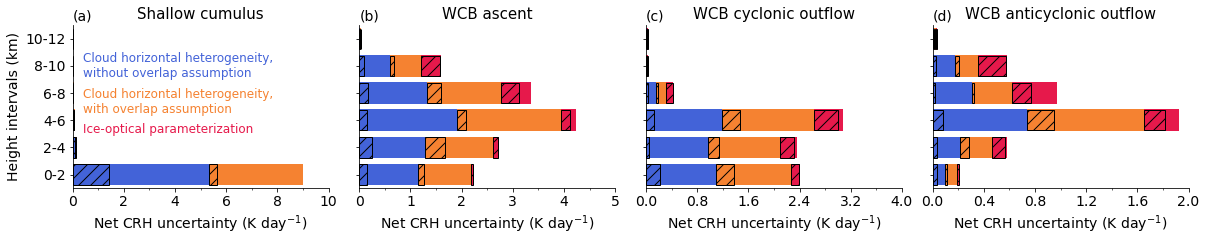

In [14]:
# height intervals
h1 = np.arange(0,6,1)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 3)) 
i = 0

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
        
    ############################################################
    ####### Net###### ##########################################
    ############################################################
    
    if i == 0:

        ax.barh(h1, d1_lunc_ho_nt, color='#4363d8', label='Horizontal heterogeneity')
        ax.barh(h1, d1_lunc_hl_nt, color='#f58231', left=d1_lunc_ho_nt, label='Horizontal heterogeneity and vertical overlap')
        #ax.barh(h1, d1_lunc_ic_nt, color='#e6194B', left=d1_lunc_3d_nt+d1_lunc_ho_nt+d1_lunc_hl_nt, label='Ice optical properties')
        
        ax.barh(h1, d1_unc_ho_nt, edgecolor='k', label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.75)
        ax.barh(h1, d1_unc_hl_nt, edgecolor='k', left=d1_lunc_ho_nt, label='Horizontal heterogeneity and vertical overlap',fill = False, hatch="//",linewidth=1,height=0.75)
        
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('Shallow cumulus', fontsize=15,pad=15)
        ax.set_xlabel('Net CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_ylabel('Height intervals (km)', fontsize=14)
        ax.set_title('Shallow cumulus', fontsize=15)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        
        ax.set_xlim([0.,10])
        ax.spines['bottom'].set_bounds(0,10)
        ax.set_xticks(np.linspace(0,10,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(a)', transform=ax.transAxes, 
            size=14)
        

        ax.text(0.4, 4.5, 'Cloud horizontal heterogeneity,\nwithout overlap assumption', color='#4363d8', size=12, va="top")
        ax.text(0.4, 3.2, 'Cloud horizontal heterogeneity,\nwith overlap assumption', color='#f58231', size=12, va="top")
        ax.text(0.4, 1.9, 'Ice-optical parameterization', color='#e6194B', size=12, va="top")
        

        #ax.text(0.3, 4.5, 'Unresoved cloud horizontal heterogeneity\nand vertical overlap', color='#4363d8', size=12, va="top")
        #ax.text(0.3, 3.2, 'Unresoved cloud horizontal heterogeneity', color='#f58231', size=12, va="top")
        #ax.text(0.3, 2.5, 'Ice-optical parameterization', color='#e6194B', size=12, va="top")
    
    if i == 1:

        ax.barh(h1, d2_lunc_ho_nt, color='#4363d8', label='Horizontal heterogeneity')
        ax.barh(h1, d2_lunc_hl_nt, color='#f58231', left=d2_lunc_ho_nt, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d2_lunc_ic_nt, color='#e6194B', left=d2_lunc_ho_nt+d2_lunc_hl_nt, label='Ice optical properties')
        
        ax.barh(h1, d2_unc_ho_nt, edgecolor='k', label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.75)
        ax.barh(h1, d2_unc_hl_nt, edgecolor='k', left=d2_lunc_ho_nt, label='Horizontal heterogeneity and vertical overlap',fill = False, hatch="//",linewidth=1,height=0.75)
        ax.barh(h1, d2_unc_ic_nt, edgecolor='k', left=d2_lunc_ho_nt+d2_lunc_hl_nt, label='Ice optical properties',fill = False, hatch="//",linewidth=1,height=0.75)
        
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB ascent', fontsize=15,pad=15)
        ax.set_xlabel('Net CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)
        ax.set_title('WCB ascent', fontsize=15)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,5])
        ax.spines['bottom'].set_bounds(0,5)
        ax.set_xticks(np.linspace(0,5,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(b)', transform=ax.transAxes, 
            size=14)
        
        
    if i == 2:


        ax.barh(h1, d3_lunc_ho_nt, color='#4363d8', label='Horizontal heterogeneity')
        ax.barh(h1, d3_lunc_hl_nt, color='#f58231', left=d3_lunc_ho_nt, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d3_lunc_ic_nt, color='#e6194B', left=d3_lunc_ho_nt+d3_lunc_hl_nt, label='Ice optical properties')
        
        ax.barh(h1, d3_unc_ho_nt, edgecolor='k', label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.75)
        ax.barh(h1, d3_unc_hl_nt, edgecolor='k', left=d3_lunc_ho_nt, label='Horizontal heterogeneity and vertical overlap',fill = False, hatch="//",linewidth=1,height=0.75)
        ax.barh(h1, d3_unc_ic_nt, edgecolor='k', left=d3_lunc_ho_nt+d3_lunc_hl_nt, label='Ice optical properties',fill = False, hatch="//",linewidth=1,height=0.75)
        
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB cyclonic outflow', fontsize=15,pad=15)
        ax.set_xlabel('Net CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)
        ax.set_title('WCB cyclonic outflow', fontsize=15)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        
        ax.text(0.0, 1.03, '(c)', transform=ax.transAxes, 
            size=14)
        
        ax.set_xlim([0.,4])
        ax.spines['bottom'].set_bounds(0,4)
        ax.set_xticks(np.linspace(0,4,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator) 
       
    if i == 3:
        
        ax.barh(h1, d4_lunc_ho_nt, color='#4363d8', label='Horizontal heterogeneity')
        ax.barh(h1, d4_lunc_hl_nt, color='#f58231', left=d4_lunc_ho_nt, label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, d4_lunc_ic_nt, color='#e6194B', left=d4_lunc_ho_nt+d4_lunc_hl_nt, label='Ice optical properties')
        
        ax.barh(h1, d4_unc_ho_nt, edgecolor='k', label='Horizontal heterogeneity',fill = False, hatch="//",linewidth=1,height=0.75)
        ax.barh(h1, d4_unc_hl_nt, edgecolor='k', left=d4_lunc_ho_nt, label='Horizontal heterogeneity and vertical overlap',fill = False, hatch="//",linewidth=1,height=0.75)
        ax.barh(h1, d4_unc_ic_nt, edgecolor='k', left=d4_lunc_ho_nt+d4_lunc_hl_nt, label='Ice optical properties',fill = False, hatch="//",linewidth=1,height=0.75)
        
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=15)
        ax.set_xlabel('Net CRH uncertainty (K day$^{-1}$)', fontsize=14)
        #ax.set_ylabel('Height intervals (km)', fontsize=14)
        ax.set_title('WCB anticyclonic outflow', fontsize=15)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,2])
        ax.spines['bottom'].set_bounds(0,2)
        ax.set_xticks(np.linspace(0,2,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        

        ax.text(0.0, 1.03, '(d)', transform=ax.transAxes, 
            size=14)
        
    i = i + 1     

fig.subplots_adjust(wspace=0.12,hspace=0.55)

#plt.text(.5, 0.91, 'Longwave', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
#plt.text(.5, 0.63, 'Shortwave', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
#plt.text(.5, 0.34, 'Total', transform=fig.transFigure, horizontalalignment='center',fontsize=15)

#plt.text((crh_unc_1[0]+crh_unc_2[0])/2,0,"{:.1f}".format(per2[0]))
#plt.text((crh_unc_1[0]+crh_unc_2[0]+crh_unc_3[0])/2,0,"{:.1f}".format(per3[0]))

plt.savefig('figure11.pdf', bbox_inches = 'tight')
plt.savefig('figure11.png', bbox_inches = 'tight',dpi=300)

In [14]:
client.close()

## Latitude-longitude plots

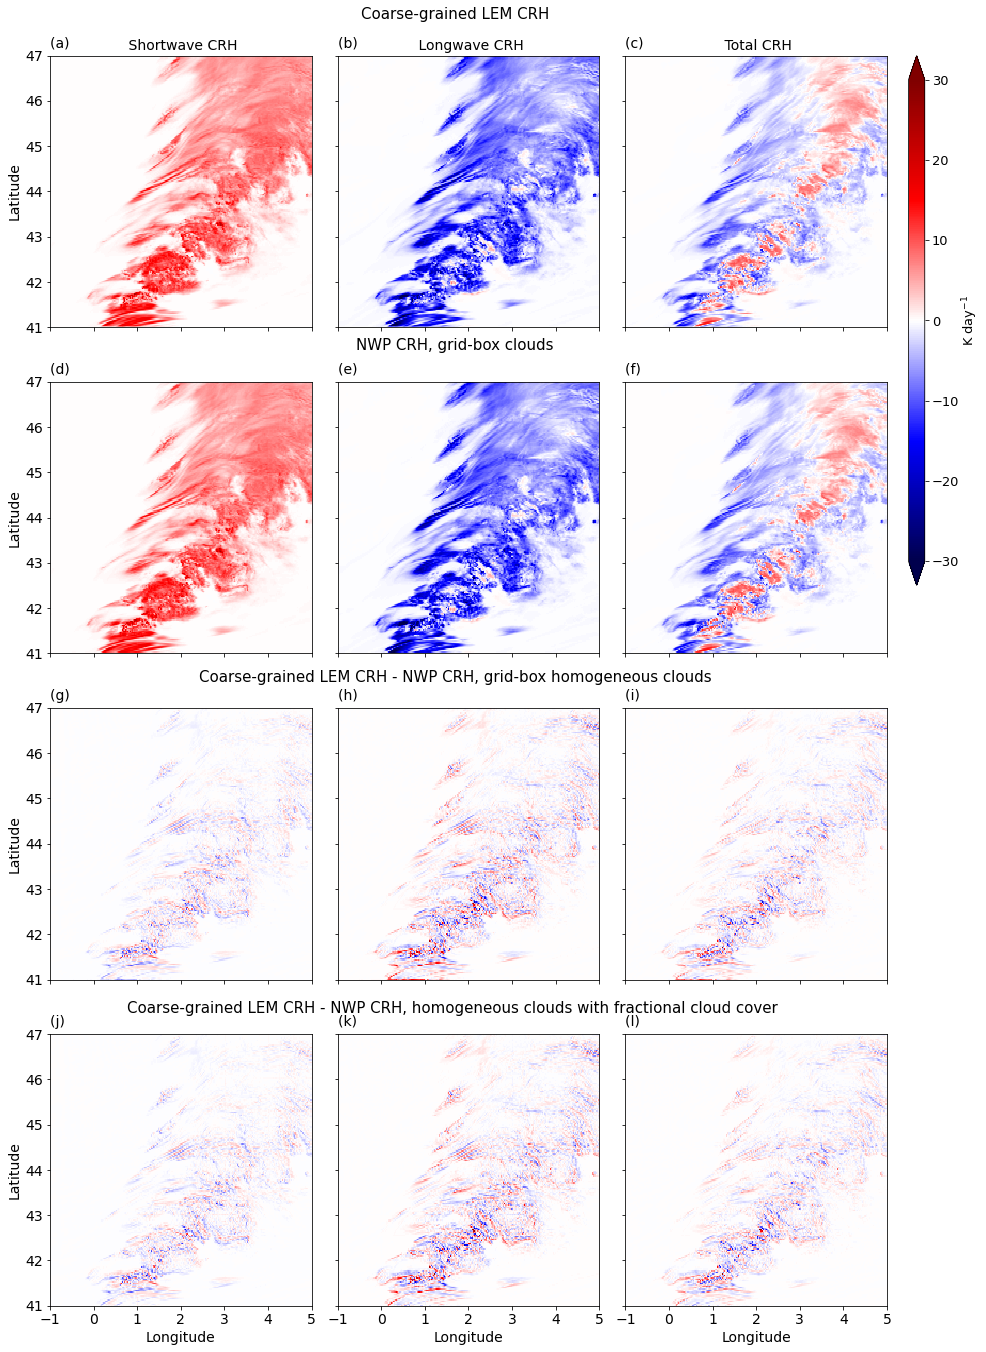

In [94]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 23))
i = 0

## coordinates for plotting
lat = np.linspace(41,47,198)
lon = np.linspace(-1,5,246)

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    
    if i == 0:
     
        im = ax.pcolor(lon,lat,ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_title(' Shortwave CRH', fontsize=14)
        ax.text(0.0, 1.03, '(a) ', transform=ax.transAxes, 
            size=14)
        
    if i == 1:    

        ax.pcolor(lon,lat,ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(' Longwave CRH', fontsize=14)
        ax.text(0.0, 1.03, '(b) ', transform=ax.transAxes, 
            size=14)
        
    if i == 2:
        
        ax.pcolor(lon,lat,(ds_lib2[1]['ddt_radlw_cg']+ds_lib2[0]['ddt_radlw_cg'])[4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(' Total CRH', fontsize=14)
        ax.text(0.0, 1.03, '(c) ', transform=ax.transAxes, 
            size=14)
        
    if i == 3:
        
        ax.pcolor(lon,lat,ds_lib2[8]['ddt_radlw'][4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_ylabel('Latitude', fontsize=14)
        ax.text(0.0, 1.03, '(d) ', transform=ax.transAxes, 
            size=14)
        
    if i == 4:
        
        ax.pcolor(lon,lat,ds_lib2[6]['ddt_radlw'][4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(e) ', transform=ax.transAxes, 
            size=14)
        
    if i == 5:
        
        ax.pcolor(lon,lat,(ds_lib2[6]['ddt_radlw']+ds_lib2[8]['ddt_radlw'])[4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(f) ', transform=ax.transAxes, 
            size=14)
        
    if i == 6:
        
        diffsw = ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[8]['ddt_radlw'][4,:,:,70].T.values
        ax.pcolor(lon,lat,diffsw,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_ylabel('Latitude', fontsize=14)
        ax.text(0.0, 1.03, '(g) ', transform=ax.transAxes, 
            size=14)
        
    if i == 7:
        
        difflw = ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[6]['ddt_radlw'][4,:,:,70].T.values
        ax.pcolor(lon,lat,difflw,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(h) ', transform=ax.transAxes, 
            size=14)
        
    if i == 8:
        
        diffsw = ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[8]['ddt_radlw'][4,:,:,70].T.values
        difflw = ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[6]['ddt_radlw'][4,:,:,70].T.values
        diffnt = difflw + diffsw
        ax.pcolor(lon,lat,diffnt,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(i) ', transform=ax.transAxes, 
            size=14)
        
    if i == 9:
        
        diffsw = ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[9]['ddt_radlw'][4,:,:,70].T.values
        ax.pcolor(lon,lat,diffsw,vmin=-30,vmax=30,cmap='seismic')
        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.text(0.0, 1.03, '(j) ', transform=ax.transAxes, 
            size=14)

    if i == 10:
        
        difflw = ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[7]['ddt_radlw'][4,:,:,70].T.values
        ax.pcolor(lon,lat,difflw,vmin=-30,vmax=30,cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xlabel('Longitude', fontsize=14)
        ax.text(0.0, 1.03, '(k) ', transform=ax.transAxes, 
            size=14)

    if i == 11:
        
        diffsw = ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[9]['ddt_radlw'][4,:,:,70].T.values
        difflw = ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[7]['ddt_radlw'][4,:,:,70].T.values
        diffnt = difflw + diffsw
        ax.pcolor(lon,lat,diffnt,vmin=-30,vmax=30,cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xlabel('Longitude', fontsize=14)
        ax.text(0.0, 1.03, '(l) ', transform=ax.transAxes, 
            size=14)
        
    i = i + 1
    
fig.subplots_adjust(wspace=0.1,hspace=0.2)

cb_ax = fig.add_axes([0.92, 0.56, 0.015, 0.32]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im,cax=cb_ax,orientation='vertical',shrink=0.95,extend='both')
cbar.set_label(label='K day$^{-1}$', size='13',labelpad=1)
cbar.ax.tick_params(labelsize=13)


plt.text(.5, 0.902, 'Coarse-grained LEM CRH', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.702, 'NWP CRH, grid-box clouds', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.502, 'Coarse-grained LEM CRH - NWP CRH, grid-box homogeneous clouds', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.302, 'Coarse-grained LEM CRH - NWP CRH, homogeneous clouds with fractional cloud cover ', transform=fig.transFigure, horizontalalignment='center',fontsize=15)

#plt.savefig('figure11.pdf', bbox_inches = 'tight')
plt.savefig('sfigure1.png', bbox_inches = 'tight',dpi=300)

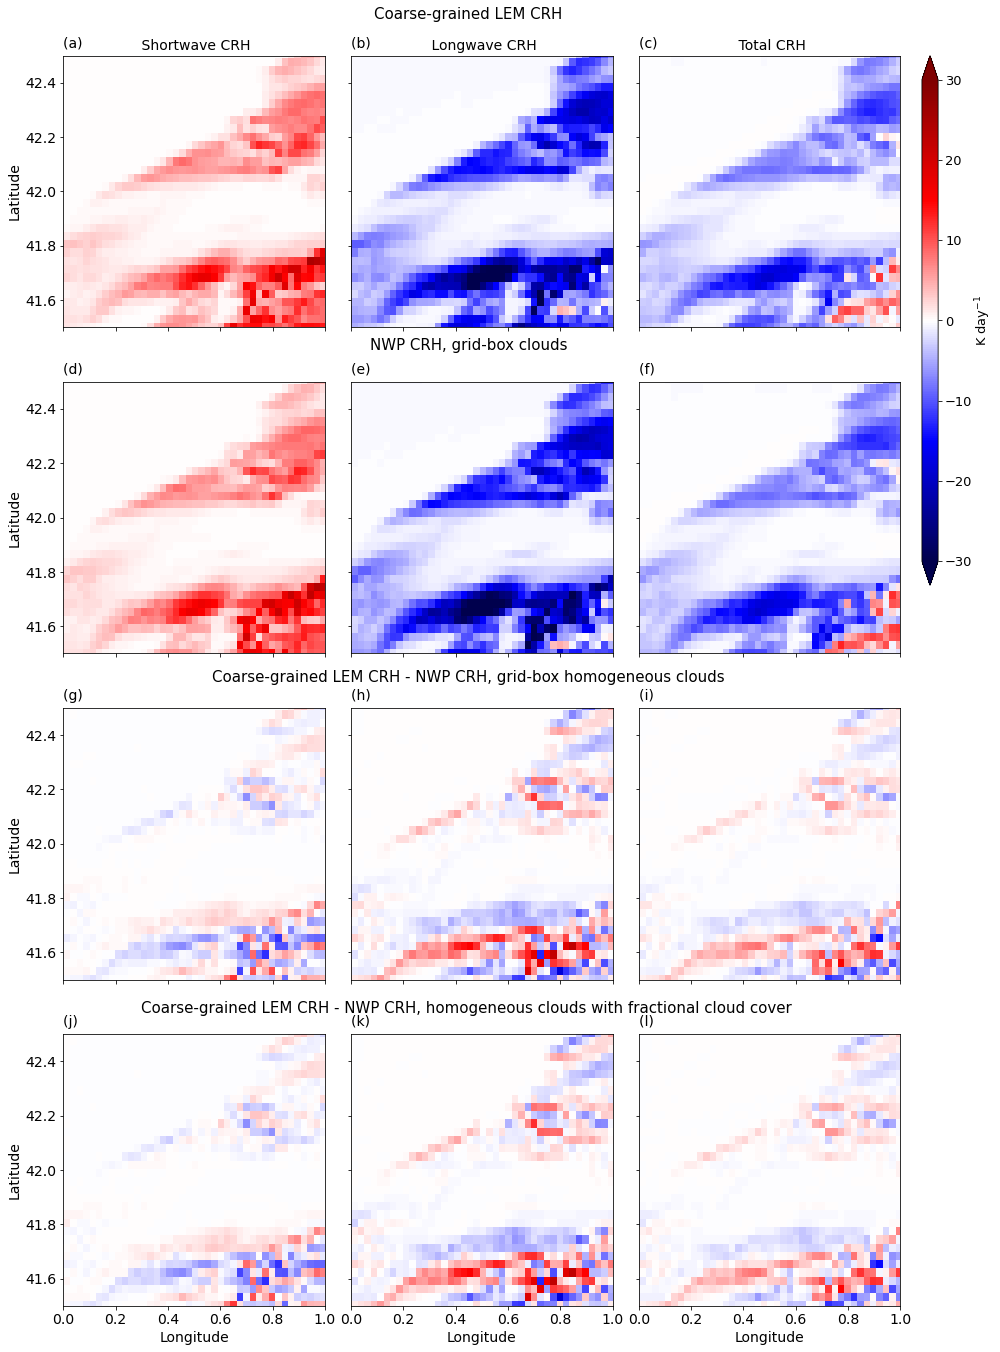

In [95]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 23))
i = 0

## coordinates for plotting
lat = np.linspace(41,47,198)
lon = np.linspace(-1,5,246)

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    ax.set_xlim([0,1])
    ax.set_ylim([41.5,42.5])
    
    if i == 0:
     
        im = ax.pcolor(lon,lat,ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_title(' Shortwave CRH', fontsize=14)
        ax.text(0.0, 1.03, '(a) ', transform=ax.transAxes, 
            size=14)
        
    if i == 1:    

        ax.pcolor(lon,lat,ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(' Longwave CRH', fontsize=14)
        ax.text(0.0, 1.03, '(b) ', transform=ax.transAxes, 
            size=14)
        
    if i == 2:
        
        ax.pcolor(lon,lat,(ds_lib2[1]['ddt_radlw_cg']+ds_lib2[0]['ddt_radlw_cg'])[4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(' Total CRH', fontsize=14)
        ax.text(0.0, 1.03, '(c) ', transform=ax.transAxes, 
            size=14)
        
    if i == 3:
        
        ax.pcolor(lon,lat,ds_lib2[8]['ddt_radlw'][4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_ylabel('Latitude', fontsize=14)
        ax.text(0.0, 1.03, '(d) ', transform=ax.transAxes, 
            size=14)
        
    if i == 4:
        
        ax.pcolor(lon,lat,ds_lib2[6]['ddt_radlw'][4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(e) ', transform=ax.transAxes, 
            size=14)
        
    if i == 5:
        
        ax.pcolor(lon,lat,(ds_lib2[6]['ddt_radlw']+ds_lib2[8]['ddt_radlw'])[4,:,:,70].T.values,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(f) ', transform=ax.transAxes, 
            size=14)
        
    if i == 6:
        
        diffsw = ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[8]['ddt_radlw'][4,:,:,70].T.values
        ax.pcolor(lon,lat,diffsw,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_ylabel('Latitude', fontsize=14)
        ax.text(0.0, 1.03, '(g) ', transform=ax.transAxes, 
            size=14)
        
    if i == 7:
        
        difflw = ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[6]['ddt_radlw'][4,:,:,70].T.values
        ax.pcolor(lon,lat,difflw,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(h) ', transform=ax.transAxes, 
            size=14)
        
    if i == 8:
        
        diffsw = ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[8]['ddt_radlw'][4,:,:,70].T.values
        difflw = ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[6]['ddt_radlw'][4,:,:,70].T.values
        diffnt = difflw + diffsw
        ax.pcolor(lon,lat,diffnt,vmin=-30,vmax=30,cmap='seismic')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.text(0.0, 1.03, '(i) ', transform=ax.transAxes, 
            size=14)
        
    if i == 9:
        
        diffsw = ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[9]['ddt_radlw'][4,:,:,70].T.values
        ax.pcolor(lon,lat,diffsw,vmin=-30,vmax=30,cmap='seismic')
        ax.set_ylabel('Latitude', fontsize=14)
        ax.set_xlabel('Longitude', fontsize=14)
        ax.text(0.0, 1.03, '(j) ', transform=ax.transAxes, 
            size=14)

    if i == 10:
        
        difflw = ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[7]['ddt_radlw'][4,:,:,70].T.values
        ax.pcolor(lon,lat,difflw,vmin=-30,vmax=30,cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xlabel('Longitude', fontsize=14)
        ax.text(0.0, 1.03, '(k) ', transform=ax.transAxes, 
            size=14)

    if i == 11:
        
        diffsw = ds_lib2[1]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[9]['ddt_radlw'][4,:,:,70].T.values
        difflw = ds_lib2[0]['ddt_radlw_cg'][4,:,:,70].T.values - ds_lib2[7]['ddt_radlw'][4,:,:,70].T.values
        diffnt = difflw + diffsw
        ax.pcolor(lon,lat,diffnt,vmin=-30,vmax=30,cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xlabel('Longitude', fontsize=14)
        ax.text(0.0, 1.03, '(l) ', transform=ax.transAxes, 
            size=14)
        
    i = i + 1
    
fig.subplots_adjust(wspace=0.1,hspace=0.2)

cb_ax = fig.add_axes([0.92, 0.56, 0.015, 0.32]) # xcenter/ycenter/width/height
cbar = fig.colorbar(im,cax=cb_ax,orientation='vertical',shrink=0.95,extend='both')
cbar.set_label(label='K day$^{-1}$', size='13',labelpad=1)
cbar.ax.tick_params(labelsize=13)


plt.text(.5, 0.902, 'Coarse-grained LEM CRH', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.702, 'NWP CRH, grid-box clouds', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.502, 'Coarse-grained LEM CRH - NWP CRH, grid-box homogeneous clouds', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.302, 'Coarse-grained LEM CRH - NWP CRH, homogeneous clouds with fractional cloud cover ', transform=fig.transFigure, horizontalalignment='center',fontsize=15)

plt.savefig('sfigure2.png', bbox_inches = 'tight',dpi=300)